In [8]:
# I'm going rogue and starting with one of the flights I'm interested in....

## Here is a list of objectives for this tutorial. Try to find (cmd-f) these numbers in the commented sections:
    # 1)  - Import our class functions and verify installation
    # 2)  - Load Drone Data
    # 3)  - Load Correlator Data
    # 4)  - Initialize a concat class for a PULSED GRID FLIGHT
    # 5)  - Perform a series of analysis functions on the concat class...
    # 5A) - concat Function: Extract_Source_Pulses
    # 5B) - concat Function: Perform_Background_Subtraction
    # 5C) - concat Function: Synchronization_Function
    # 5D) - concat Function: Export_yaml
    # 5E) - concat Function: Main_Beam_Fitting

In [9]:
## First import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import h5py
import datetime
import pytz

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

In [10]:
# Useful analysis stuff I will need to somehow code:
Epols = [0,3,4,7,9,10,12,14]
Npols = [1,2,5,6,8,11,13,15]
# dishes are 2n, 2n+1 pairs

print(gbosite.chmap)
for i,chan in enumerate(gbosite.chmap): print(i, chan)

[ 0  1  3  2  4  5  7  6  9  8 10 11 12 13 14 15]
0 0
1 1
2 3
3 2
4 4
5 5
6 7
7 6
8 9
9 8
10 10
11 11
12 12
13 13
14 14
15 15


In [11]:
###################
#### FUNCTIONS ####
###################

In [12]:
def plot_something(drone_class,coo,t_bounds=[0,-1]):
    print('plotting drone coordinates for all time samples:')
    fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(15,9))
    ## Plot p0 coordinate origin:
    ax1.plot(drone_class.origin[0],drone_class.origin[1],'ro')
    ax2.axhline(drone_class.origin[0],c='b')
    ax3.axhline(drone_class.origin[1],c='b')
    ## Title each coordinate subplot:        
    ax1.set_title('Lat vs Lon')
    ax2.set_title('Lat vs Time')
    ax3.set_title('Lon vs Time')
    ax4.set_title('Velocity vs Time')
    ax5.set_title('Altitude vs Time')
    ax6.set_title('Yaw vs Time')
    ## Specify arrays/vectors to plot in 1,3,4 coordinate subplot
    if coo=='lat':
        xqtys=[drone_class.latitude,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index]
        yqtys=[drone_class.longitude,drone_class.latitude,drone_class.longitude,drone_class.velocity,drone_class.altitude,drone_class.yaw]
        xtags=['Latitude, [$deg$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
        ytags=['Longitude, [$deg$]','Latitude, [$deg$]','Longitude, [$deg$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
        print('overplotting drone coordinates for t_cut samples: ['+str(t_bounds[0])+':'+str(t_bounds[1])+']')
        for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
            ax.plot(np.nanmin(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmin(yqtys[i][t_bounds[0]:t_bounds[1]]))
            ax.plot(np.nanmax(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmax(yqtys[i][t_bounds[0]:t_bounds[1]]))
            autoscalelims=ax.axis()
            ax.clear()
            ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
            ax.plot(xqtys[i][t_bounds[0]:t_bounds[1]],yqtys[i][t_bounds[0]:t_bounds[1]],'.',label='selected samples')
            ax.set_xlabel(xtags[i])
            ax.set_ylabel(ytags[i])
            ax.grid()
            ax.legend()
            ax.set_xlim(autoscalelims[0],autoscalelims[1])
            ax.set_ylim(autoscalelims[2],autoscalelims[3])
        tight_layout()
      
    if coo=='xy':
        xqtys=[drone_class.coords_xyz_LC[:,0],drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index,drone_class.t_index]
        yqtys=[drone_class.coords_xyz_LC[:,1],drone_class.coords_xyz_LC[:,0],drone_class.coords_xyz_LC[:,1],drone_class.velocity,drone_class.altitude,drone_class.yaw]
        xtags=['X, [$m$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
        ytags=['Y, [$m$]','X [$m$]','Y [$m$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
        print('overplotting drone coordinates for t_cut samples: ['+str(t_bounds[0])+':'+str(t_bounds[1])+']')
        for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
            ax.plot(np.nanmin(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmin(yqtys[i][t_bounds[0]:t_bounds[1]]))
            ax.plot(np.nanmax(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmax(yqtys[i][t_bounds[0]:t_bounds[1]]))
            autoscalelims=ax.axis()
            ax.clear()
            ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
            ax.plot(xqtys[i][t_bounds[0]:t_bounds[1]],yqtys[i][t_bounds[0]:t_bounds[1]],'.',label='selected samples')
            ax.set_xlabel(xtags[i])
            ax.set_ylabel(ytags[i])
            ax.grid()
            ax.legend()
            ax.set_xlim(autoscalelims[0],autoscalelims[1])
            ax.set_ylim(autoscalelims[2],autoscalelims[3])
        tight_layout()
        

# 2. Reading in Gaussian fit params from fit files and comparing

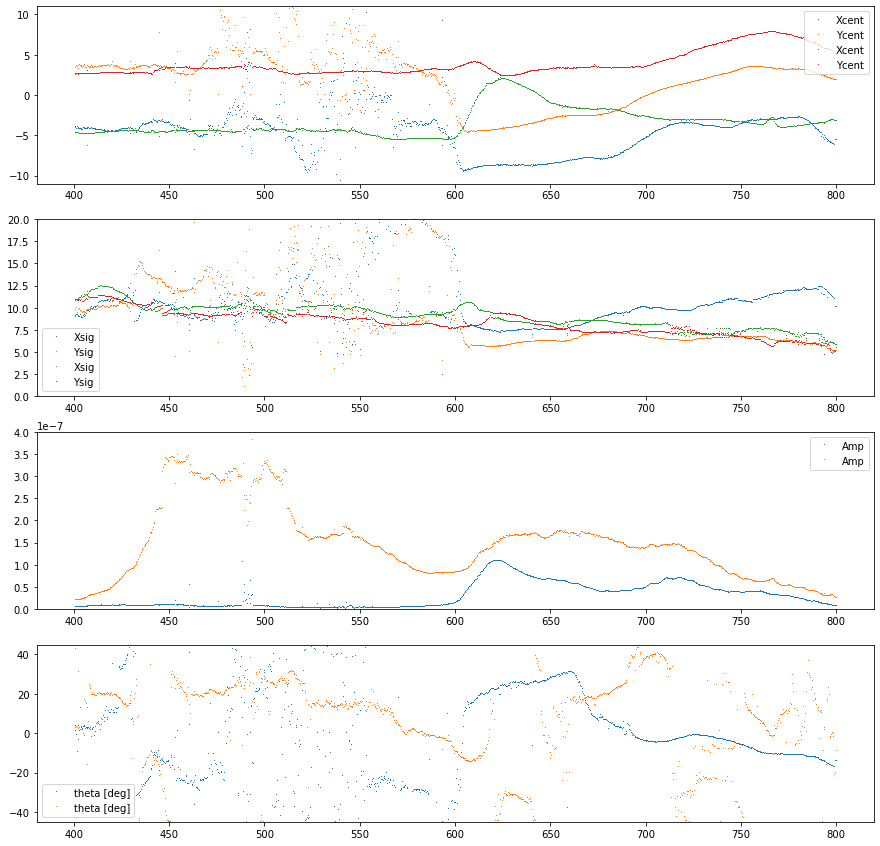

In [13]:
fitdir = '/hirax/GBO_Analysis_Outputs/main_beam_fits/'
#ffiles = ['FLY527_20210826T170313Z_ver_20230130T125043_2dGauss_and_Airy_Params.npz',
#         'FLY533_20210826T182904Z_ver_20220923T151220_2dGauss_and_Airy_Params.npz']
#ffiles = ['FLY534_20210826T185621Z_ver_20220819T120232_2dGauss_and_Airy_Params.npz',
#          'FLY534_20210826T185621Z_ver_20230201T154528_2dGauss_and_Airy_Params.npz',
#         'FLY534_20210826T185621Z_ver_20230201T161051_2dGauss_and_Airy_Params.npz',
#         'FLY534_20210826T185621Z_ver_20230201T221808_2dGauss_and_Airy_Params.npz']
#ffiles = ['FLY527_20210826T170313Z_ver_20230130T125043_2dGauss_and_Airy_Params.npz',
#          'FLY527_20210826T170313Z_ver_20230201T165007_2dGauss_and_Airy_Params.npz']
#ffiles = ['FLY533_20210826T182904Z_ver_20220923T151220_2dGauss_and_Airy_Params.npz',
#          'FLY533_20210826T182904Z_ver_20230201T211019_2dGauss_and_Airy_Params.npz']

#ffiles = ['FLY527_20210826T170313Z_ver_20230201T165007_2dGauss_and_Airy_Params.npz',
#         'FLY533_20210826T182904Z_ver_20230201T211019_2dGauss_and_Airy_Params.npz']



ffiles = ['FLY533_20210826T182904Z_ver_20230201T211019_2dGauss_and_Airy_Params.npz',
         'FLY535_20210826T192056Z_ver_20230202T100505_2dGauss_and_Airy_Params.npz']

fig, axs = plt.subplots(4,1,figsize=(15, 15))

for i in range(0,len(ffiles)):
    fits = np.load(fitdir+ffiles[i])
    #for key in fits.keys():
    #    print(key)
    
    axs[0].plot(freqs,fits['G_popt'][0,:,1],marker=',',linestyle='None',label='Xcent')
    axs[0].plot(freqs,fits['G_popt'][0,:,3],marker=',',linestyle='None',label='Ycent')
    axs[0].set_ylim(-11,11)

    axs[1].plot(freqs,fits['G_popt'][0,:,2],marker=',',linestyle='None',label='Xsig')
    axs[1].plot(freqs,fits['G_popt'][0,:,4],marker=',',linestyle='None',label='Ysig')
    axs[1].set_ylim(0,20)

    axs[2].plot(freqs,fits['G_popt'][0,:,0],marker=',',linestyle='None',label='Amp')
    axs[2].set_ylim(0,4E-7)

    axs[3].plot(freqs,np.degrees(fits['G_popt'][0,:,5]),marker=',',linestyle='None',label='theta [deg]')
    axs[3].set_ylim(-45,45)
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

in Epols 0 1.690720526515595e-09
in Npols 1 3.3453677212169117e-08
in Epols 2 3.744973124639042e-08
in Npols 3 2.9621499965093435e-09
in Epols 4 nan
in Npols 5 nan
in Epols 6 1.8658239496762823e-07
in Npols 7 1.0544575840842752e-08
in Epols 8 8.331525668277983e-08
in Npols 9 3.193205424163465e-09
in Epols 10 3.8592595664867775e-09
in Npols 11 2.0715701558000168e-08
in Epols 12 3.078080762547492e-08
in Npols 13 nan
in Epols 14 4.4730332197357844e-10
in Npols 15 5.416710942164184e-08


IndexError: list index out of range

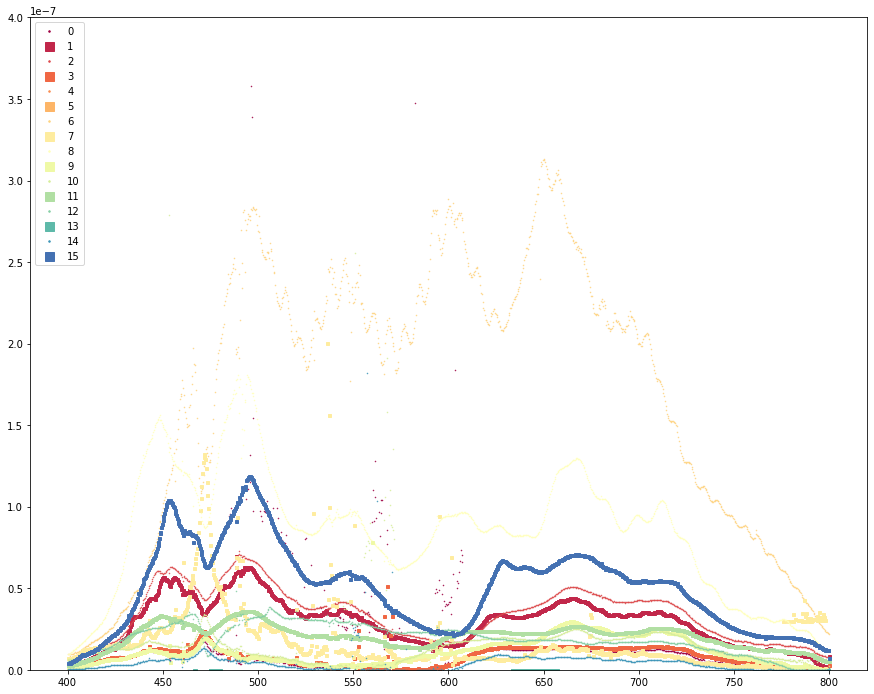

In [18]:
########################################################################
# Mild Excursion to find mapping between iterator and polarizaiton 
########################################################################

ffiles = ['FLY533_20210826T182904Z_ver_20230201T211019_2dGauss_and_Airy_Params.npz',
         'FLY535_20210826T192056Z_ver_20230202T100505_2dGauss_and_Airy_Params.npz']
# flight 533 is N pol flight, flight 535 is E pol flight
ffiles = ['FLY613_20211021T144905Z_2dGauss_and_Airy_Params.npz']

#Epols = [0,3,4,7,9,10,12,14]
#Npols = [1,2,5,6,8,11,13,15]

fits = np.load(fitdir+ffiles[0])
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])
f = 700
for i in range(0,N):
    if (i in Epols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='.',ms=1,linestyle='None',label=str(i))
        print('in Epols',i,fits['G_popt'][i,f,0])
    if (i in Npols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='s',ms=3,linestyle='None',label=str(i))
        print('in Npols',i,fits['G_popt'][i,f,0])
    ax.set_ylim(0,4E-7)
    #ax.set_xlim(400,575)
    #ylabel('Gaussian fit amplitude')
    #xlabel('Frequency [MHz]')
    #title('Flight 535')
ax.legend(markerscale=3)
fig.show()

fits = np.load(fitdir+ffiles[1])
print(len(fits['G_popt'][:,0,0]),len(fits['G_popt'][0,:,0]),len(fits['G_popt'][0,0,:]))

cm = plt.get_cmap('Spectral')
N = len(fits['G_popt'][:,400,0])
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])
f = 700
for i in range(0,N):
    if (i in Epols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='.',ms=1,linestyle='None',label=str(i))
        print('in Epols',i,fits['G_popt'][i,f,0])
    if (i in Npols):
        ax.plot(freqs,fits['G_popt'][i,:,0],marker='s',ms=3,linestyle='None',label=str(i))
        print('in Npols',i,fits['G_popt'][i,f,0])
    ax.set_ylim(0,4E-7)
    ax.set_xlim(400,575)
    #ylabel('Gaussian fit amplitude')
    #xlabel('Frequency [MHz]')
    #title('Flight 535')
ax.legend(markerscale=3)
fig.show()



<Figure size 1080x864 with 0 Axes>

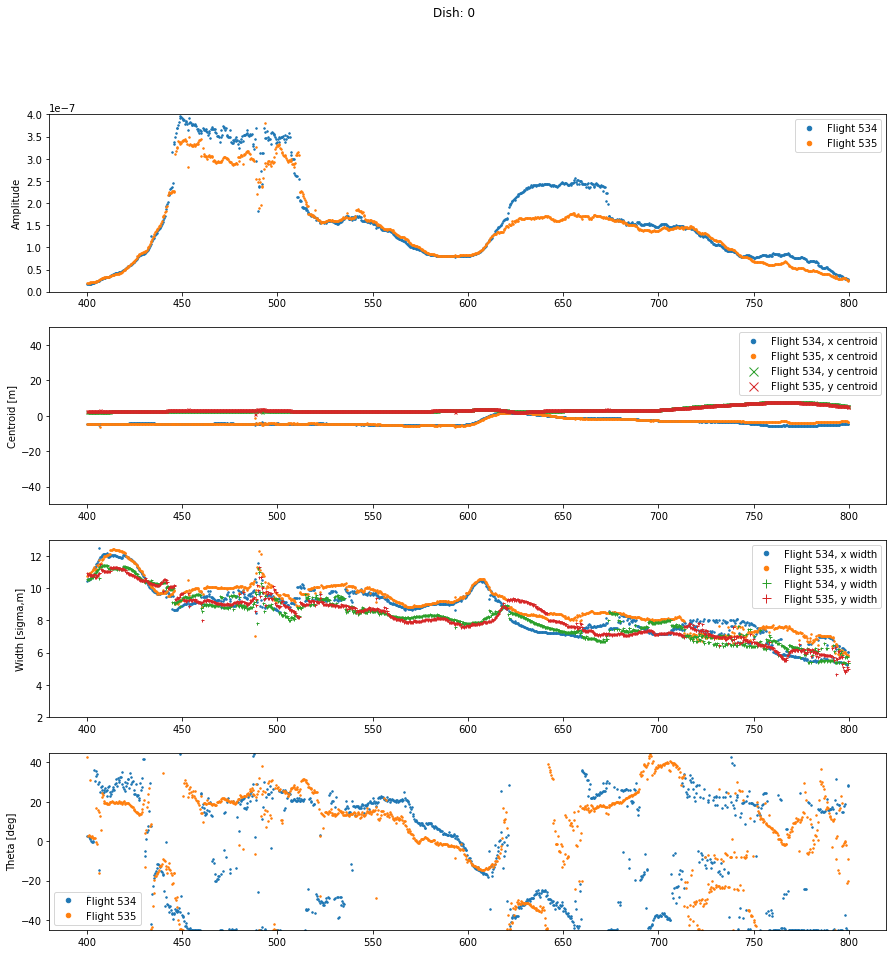

<Figure size 1080x864 with 0 Axes>

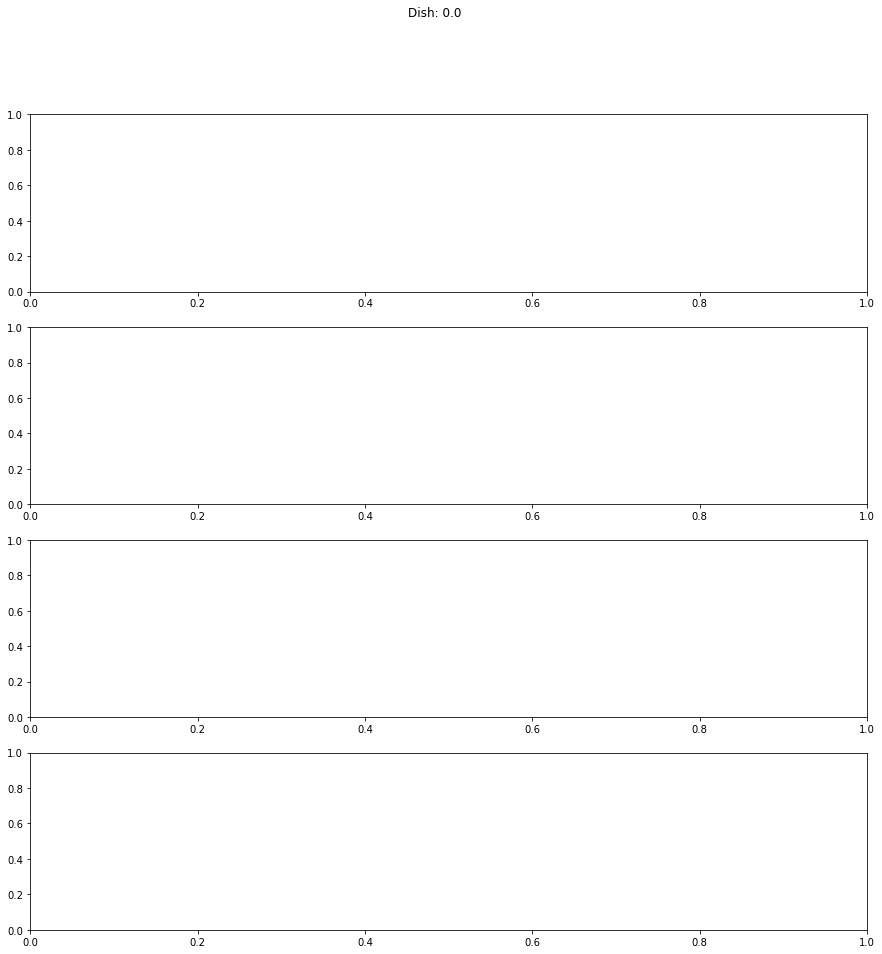

<Figure size 1080x864 with 0 Axes>

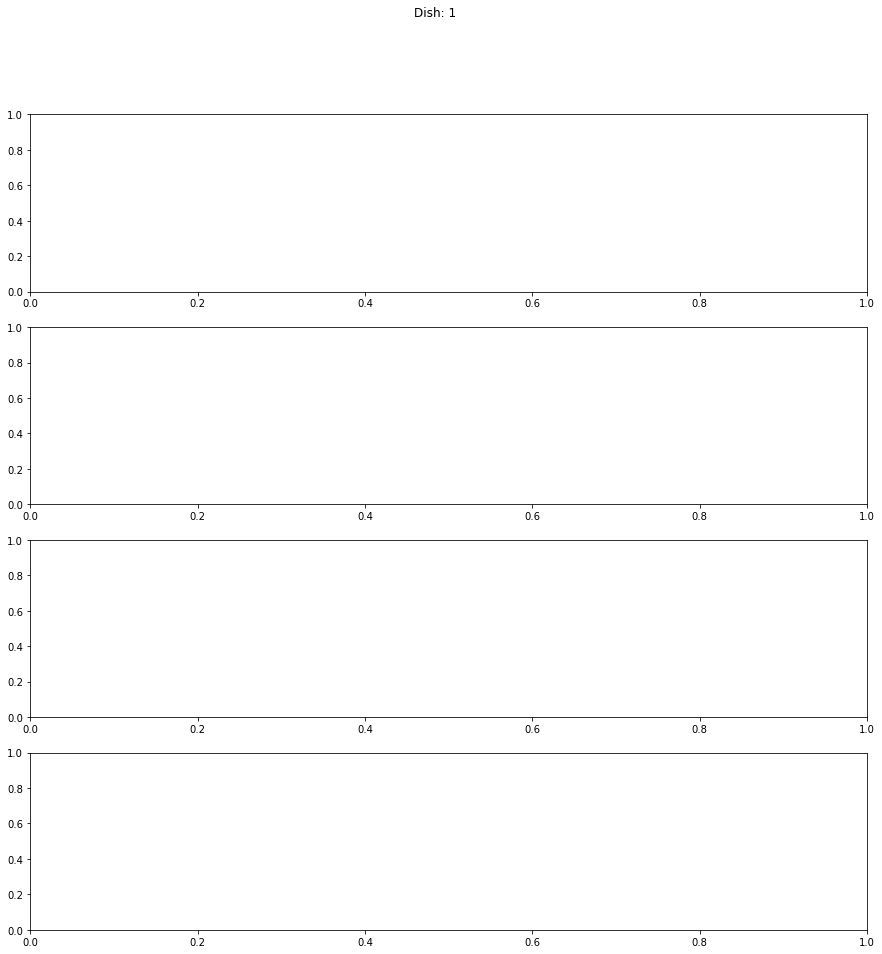

<Figure size 1080x864 with 0 Axes>

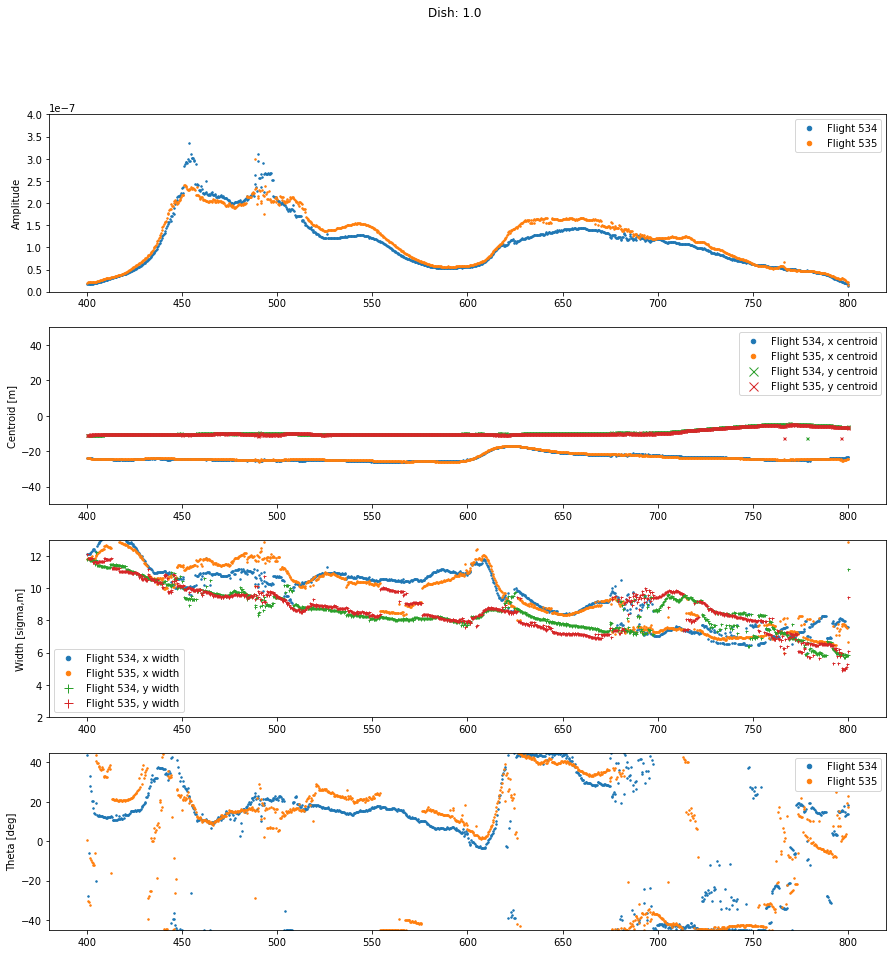

<Figure size 1080x864 with 0 Axes>

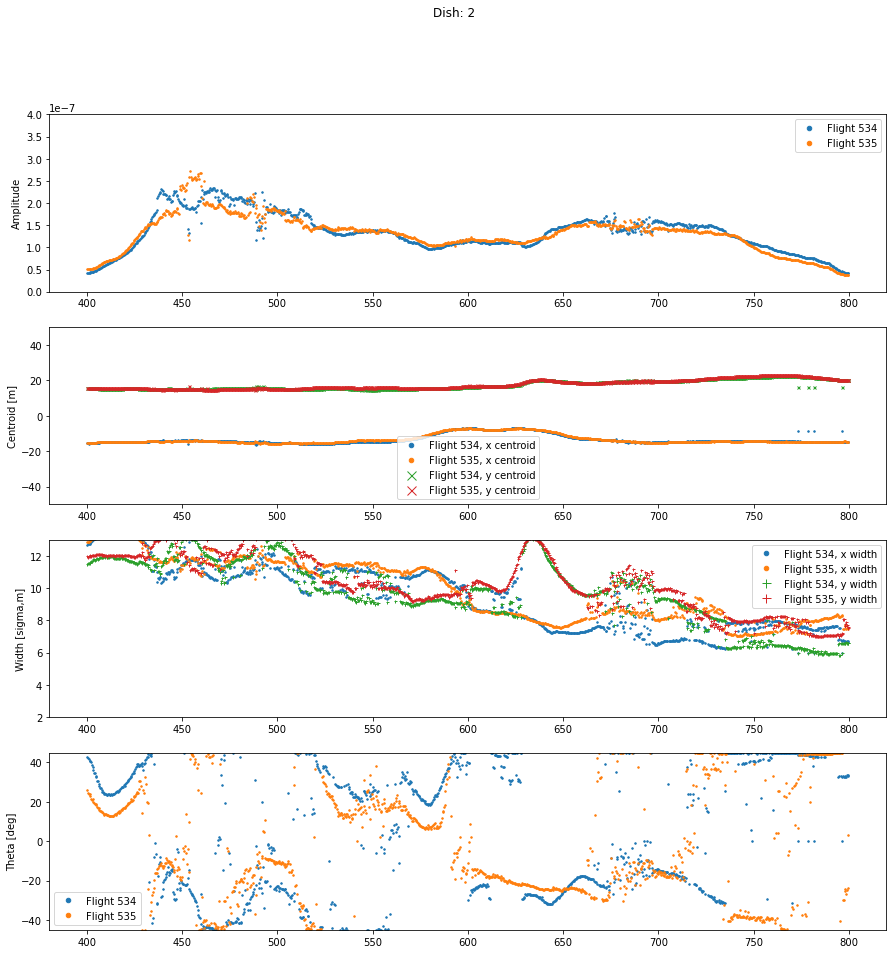

<Figure size 1080x864 with 0 Axes>

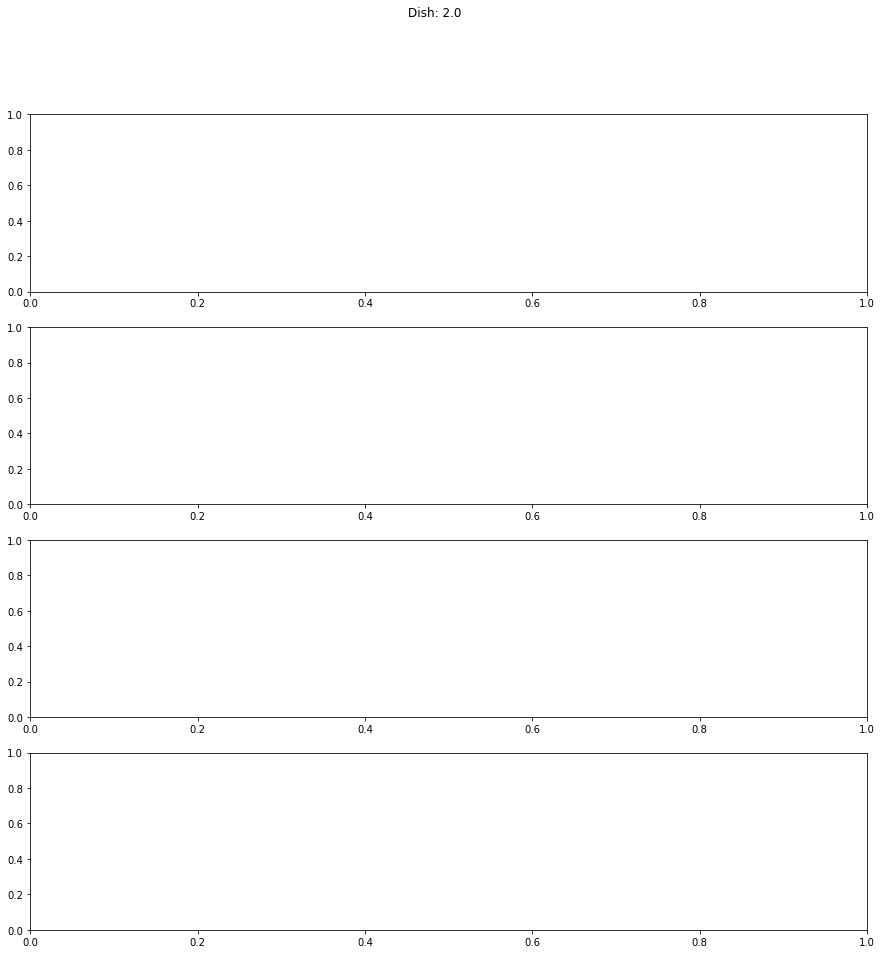

<Figure size 1080x864 with 0 Axes>

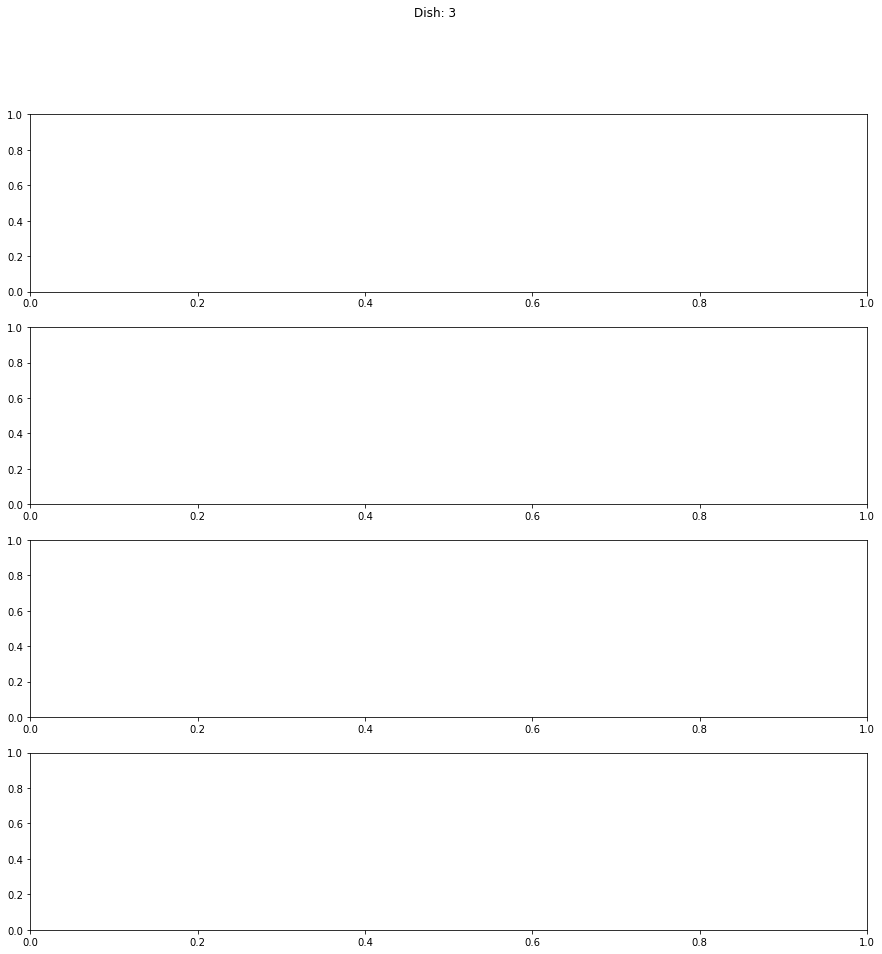

In [90]:
########################################################################
# Lets look at one dish, the same pol, between two similar pol flights 
########################################################################

ffiles = ['FLY534_20210826T185621Z_ver_20230201T221808_2dGauss_and_Airy_Params.npz',
         'FLY535_20210826T192056Z_ver_20230202T100505_2dGauss_and_Airy_Params.npz']

# These are both E pol flights, use only Epols. Flight 534 only has 0-7 inputs
# That means I only expect 3 comparisons: [0,3,4], so dishes 0, 1, 2

fits1 = np.load(fitdir+ffiles[0])
fits2 = np.load(fitdir+ffiles[1])

cm = plt.get_cmap('Spectral')
N = 7

for i in range(0,N):
    
    fig = plt.figure(figsize=(15,12))
    #ax = fig.add_subplot(111)
    fig, axs = plt.subplots(4,1,figsize=(15, 15))
    ax.set_prop_cycle(color=[cm(1.*i/N) for i in range(N)])


    if (i % 2) == 0: dish = str(int(i/2))
    if (i % 2) != 0: dish = str(np.floor(i/2))
    fig.suptitle('Dish: '+dish)
    if (i in Epols):
        axs[0].plot(freqs,fits1['G_popt'][i,:,0],marker='.',ms=3,linestyle='None',label='Flight 534')
        axs[0].plot(freqs,fits2['G_popt'][i,:,0],marker='.',ms=3,linestyle='None',label='Flight 535')
        axs[0].set_ylim(0,4E-7)
        #axs[0].set_xlim(400,575)
        axs[0].set_ylabel('Amplitude')
        axs[0].legend(markerscale=3)

        axs[1].plot(freqs,fits1['G_popt'][i,:,1],marker='.',ms=3,linestyle='None',label='Flight 534, x centroid')
        axs[1].plot(freqs,fits2['G_popt'][i,:,1],marker='.',ms=3,linestyle='None',label='Flight 535, x centroid')
        axs[1].plot(freqs,fits1['G_popt'][i,:,3],marker='x',ms=3,linestyle='None',label='Flight 534, y centroid')
        axs[1].plot(freqs,fits2['G_popt'][i,:,3],marker='x',ms=3,linestyle='None',label='Flight 535, y centroid')
        axs[1].set_ylim(-50,50)
        #axs[0].set_xlim(400,575)
        axs[1].set_ylabel('Centroid [m]')
        axs[1].legend(markerscale=3)
        
        axs[2].plot(freqs,fits1['G_popt'][i,:,2],marker='.',ms=3,linestyle='None',label='Flight 534, x width')
        axs[2].plot(freqs,fits2['G_popt'][i,:,2],marker='.',ms=3,linestyle='None',label='Flight 535, x width')
        axs[2].plot(freqs,fits1['G_popt'][i,:,4],marker='+',ms=3,linestyle='None',label='Flight 534, y width')
        axs[2].plot(freqs,fits2['G_popt'][i,:,4],marker='+',ms=3,linestyle='None',label='Flight 535, y width')
        axs[2].set_ylim(2,13)
        #axs[0].set_xlim(400,575)
        axs[2].set_ylabel('Width [sigma,m]')
        axs[2].legend(markerscale=3)
        
        axs[3].plot(freqs,np.degrees(fits1['G_popt'][i,:,5]),marker='.',ms=3,linestyle='None',label='Flight 534')
        axs[3].plot(freqs,np.degrees(fits2['G_popt'][i,:,5]),marker='.',ms=3,linestyle='None',label='Flight 535')
        axs[3].set_ylim(-45,45)
        #axs[0].set_xlim(400,575)
        axs[3].set_ylabel('Theta [deg]')
        axs[3].legend(markerscale=3)
        fig.show()



array([ 0,  1,  3,  2,  4,  5,  7,  6,  9,  8, 10, 11, 12, 13, 14, 15])

# 1. Fitting time offsets, background, writing yamls and Gaussian values 

In [19]:
# Checking if the flight and numbers correspond from what I've written in the spreadsheet


fly = '534'
cdat = '20210826T185621Z'

#fly = '535'
#cdat = '20210826T192056Z'

#process='yes'

dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite)

print('start time: ', datetime.datetime.now())

#if process=='yes':
#    mdir='/hirax/GBO_Aug_2021/TONE_ACQ/processed/'+cdat+'_yale_drone/corr/' # August 2021
#    #mdir='/hirax/GBO_Oct_2021/TONE_ACQ/processed_new/'+cdat+'_yale_drone/corr/' # Oct 2021
#    sdir = os.listdir(mdir)[0]
#
#    datadir=mdir+sdir+'/'
#    gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
#    #gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021
#else:
mdir='/hirax/GBO_Aug_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # August 2021
#mdir='/hirax/GBO_Oct_2021/TONE_ACQ/'+cdat+'_yale_drone/corr/' # Oct 2021
sdir = os.listdir(mdir)[0]

datadir=mdir+sdir+'/'
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # August 2021
#gaindir='/hirax/GBO_Oct_2021/TONE_ACQ/digital_gains/'+cdat+'_yale_drone_yale_digitalgain/' # Oct 2021
print(datadir,gaindir)
corrtest0825=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])
print('end time: ', datetime.datetime.now())

Initializing drone data via datcon_csv routine: FLY534.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 12316/12316 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
start time:  2023-02-06 13:17:02.081275
/hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/ /hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T185621Z_yale_drone_yale_digitalgain/
Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/
  --> Arrays initialized with shape (97, 256, 1024, 8)
Assigning array values by reading in data files:
  --> Loading File: 0096/0096
  --> Finished. Reshaping arrays.
end time:  2023-02-06 13:19:31.351363


plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


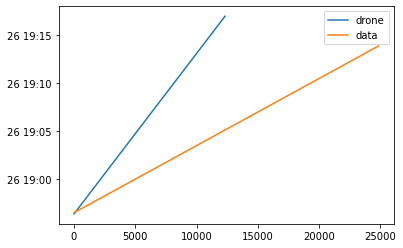

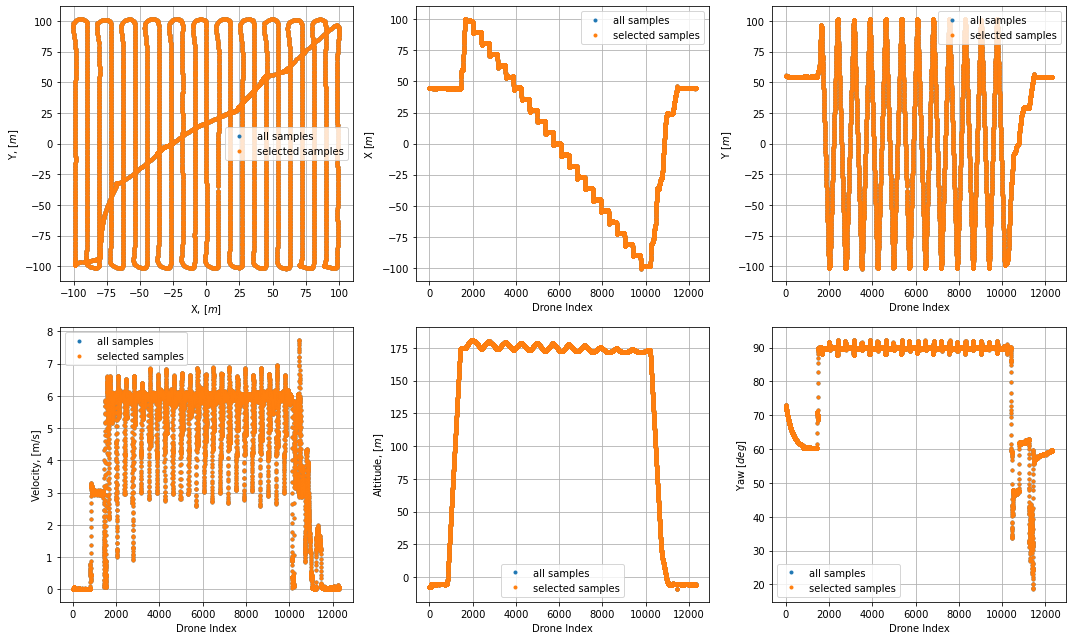

In [20]:
# putting checks in one cell now that I know I've mostly figured out the flight/corr file correspondence
# This checks I copied and pasted ok :)

## plot their datetime arrays to check overlap:

plot(dronetest0825.t_arr_datetime,label='drone')
plot(corrtest0825.t_arr_datetime,label='data')
legend()

plot_something(dronetest0825,'xy',t_bounds=[0,-1])

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/
  --> FLY534.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/FLY534_20210826T185621Z_ver_20230206T132003/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 24832 elements
  --> drone timestamp axis contains 12316 elements


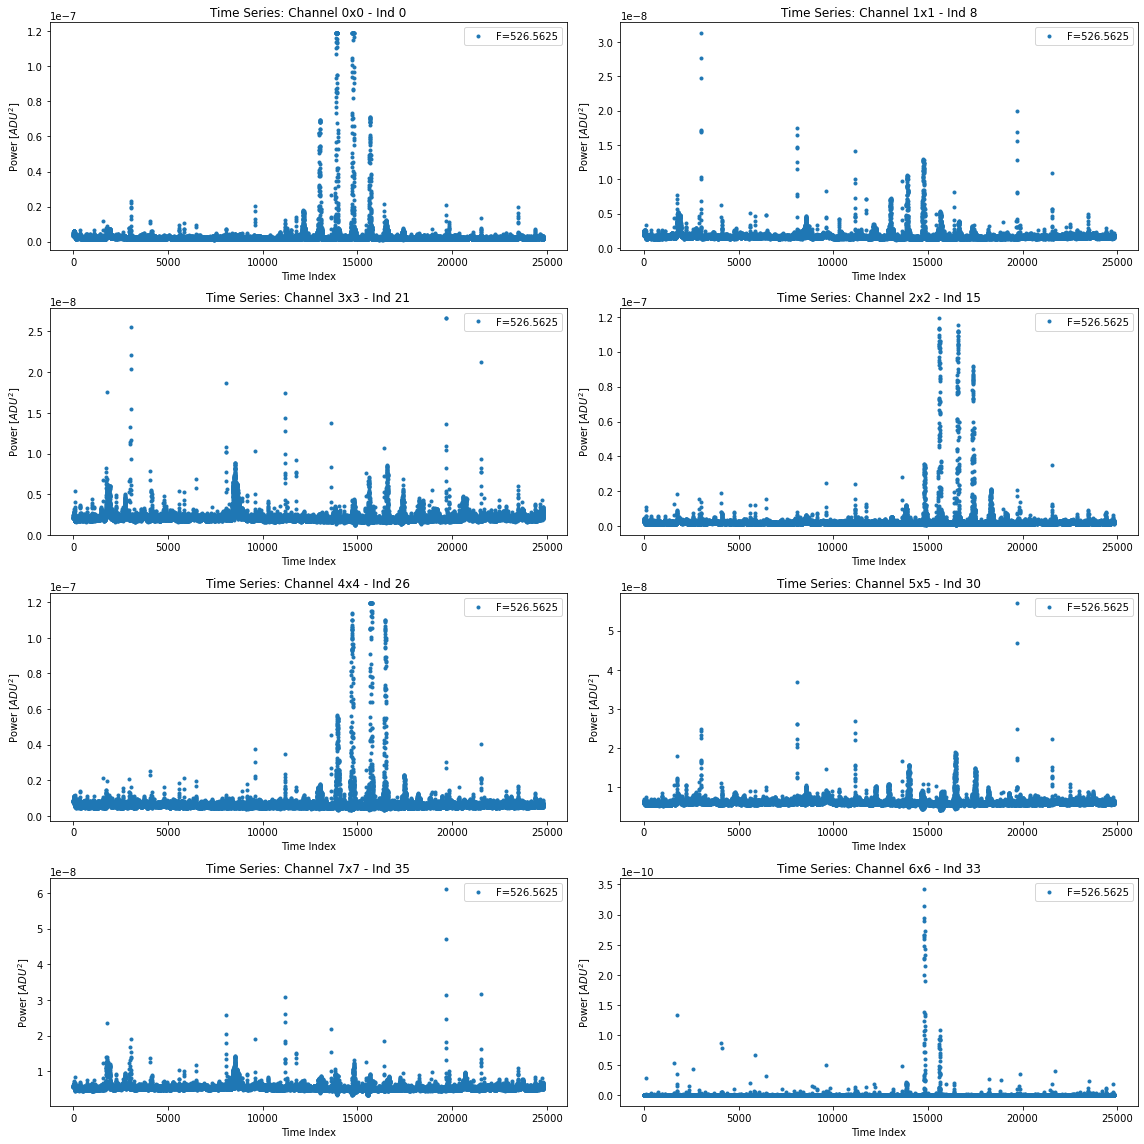

In [21]:
# Match drone and correlator data together, and plot a few frequencies

#concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             #load_yaml=True,traceback=True,save_traceback=False)
concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825, 
                             load_yaml=False,traceback=True,save_traceback=True)

pu.Plot_Time_Series(concattest0825,freqlist=[700])#freqlist=[200,400,700,900])

(15000.0, 22000.0)

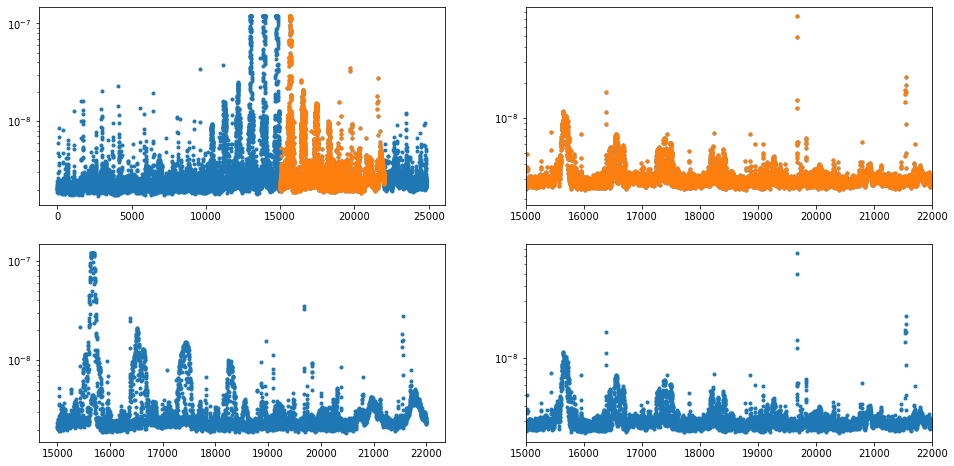

In [22]:
## Let's find the time bounds for a central transit, and examine those bounds when we solve for the source pulses:
tlb,tub=[15000,22000]
find=900

fig=figure(figsize=(16,8))
for i in range(concattest0825.n_channels)[:2]:
    ax1=fig.add_subplot(2,2,i+1)
    ax2=fig.add_subplot(2,2,i+3)
    ax1.semilogy(concattest0825.t_index[:],concattest0825.V[:,find,concattest0825.chmap[i]],'.')
    for ax in [ax1,ax2]:
        ax.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb:tub,find,concattest0825.chmap[i]],'.')
ax1.set_xlim(tlb,tub)
ax2.set_xlim(tlb,tub)

## So we've identified time bounds where we can see the pulsing source transit!
    ## Infact, I think we are seeing a sidelobe on channel 1!
    ## Let's see if we can extract the on/off indices...

Maximum Pearson_R Correlations between data and square wave function:
  --> t_indices = [463. 459. 461. 459. 466. 460. 457. 460.]
  --> t_deltas = [-0.215 -0.216 -0.215 -0.216 -0.213 -0.216 -0.217 -0.216]
Selecting square wave function time offset:
  --> t_delta_pulse = -0.2158158158
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


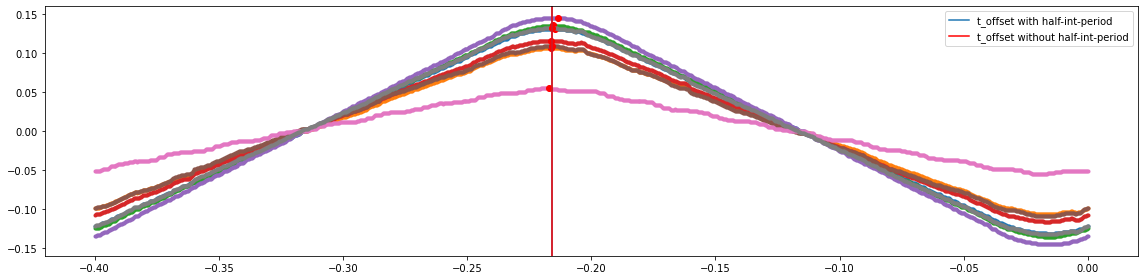

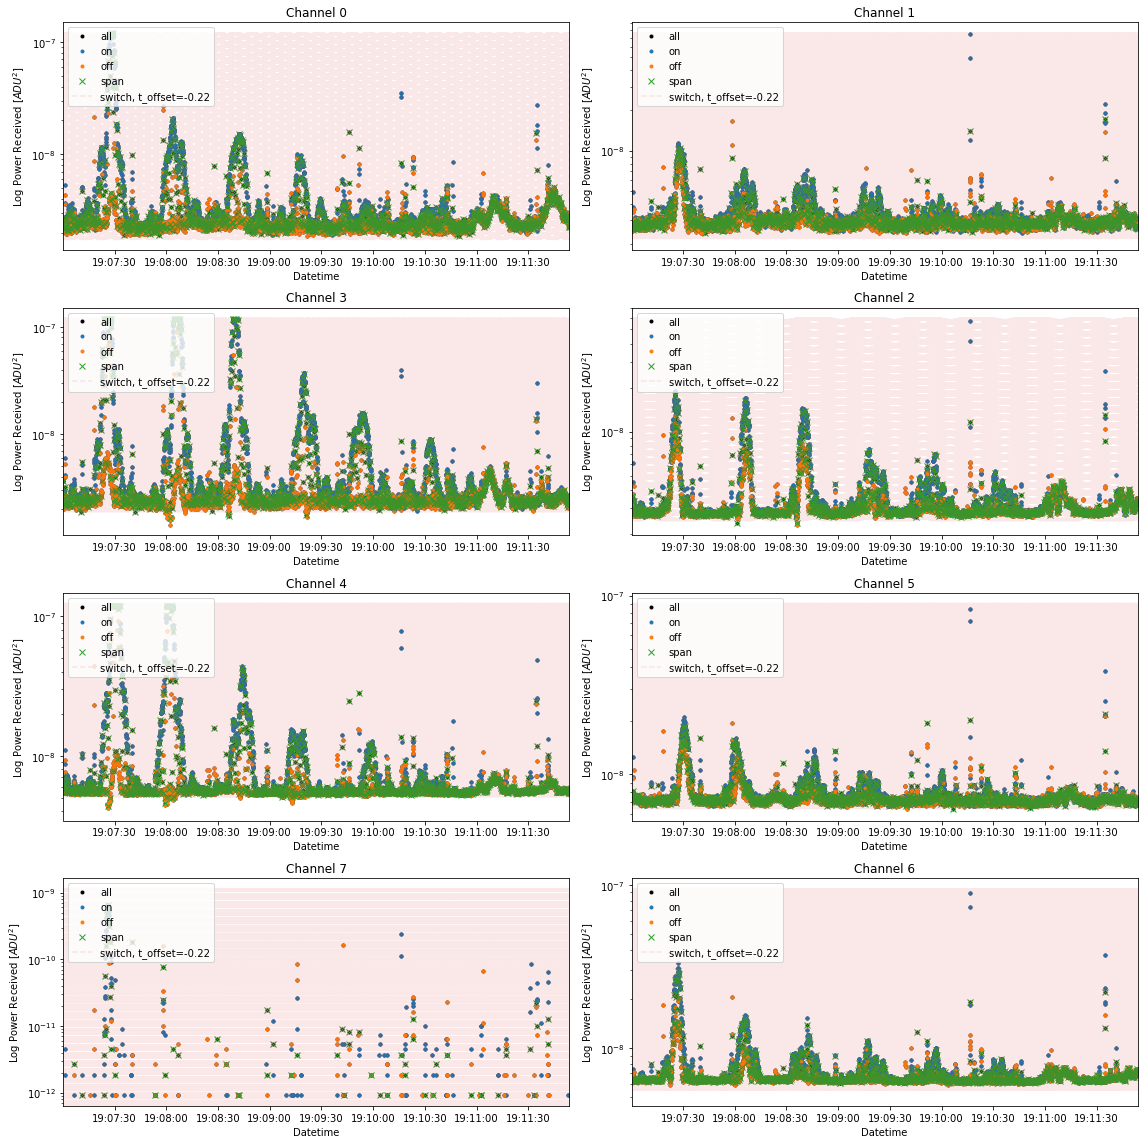

In [23]:
## OBJECTIVE 5A: concat Function: Extract_Source_Pulses

## Let's use the Extract_Source_Pulses function:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine.
## Fortunately, these parameters are loaded from the config, so we don't have to wait for the solver to run.
    ## The returned t_delta_pulse parameter will be given in seconds.
    ## In the verification plot, we should see the following points plotted:
        # orange_o = inds_off  = times when the source is off
        # blue_o   = inds_on   = times when the source is on and broadcasting
        # green_x  = inds_span = times where the behavior changes during the integration period (omit always!)
    ## The print statements shows the list of indices that appear in more than one of on/off/span.
        ## If they are all empty lists [], then there is no overlap which is a good thing.
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[tlb,tub])

In [24]:
## OBJECTIVE 5B: concat Function: Perform_Background_Subtraction

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
    # This function only works if the source was pulsed and Extract_Source_Pulses was used!
concattest0825.Perform_Background_Subtraction(window_size=5)

Calculating background spectra from indices where the noise source is off.
  --> Background subtraction completed using window_size = 5


Synchronizing data from correlator and drone:
  --> Previous t_delta_dji not found
  --> Calculating via 2DGauss fitting routine:
Applying a time correction of -1.38 seconds using Channel 0 fits.
  --> Variable synchronation successful, generating output plots:
  --> Saving output plot.


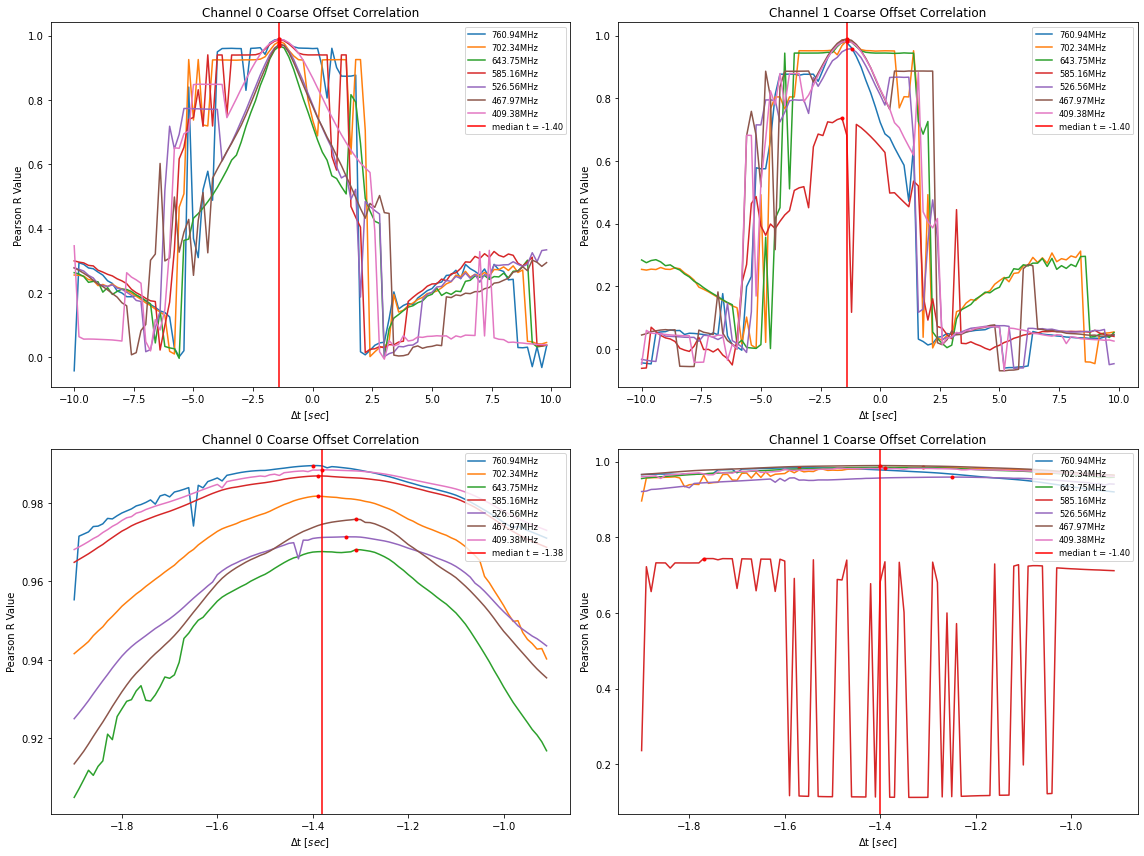

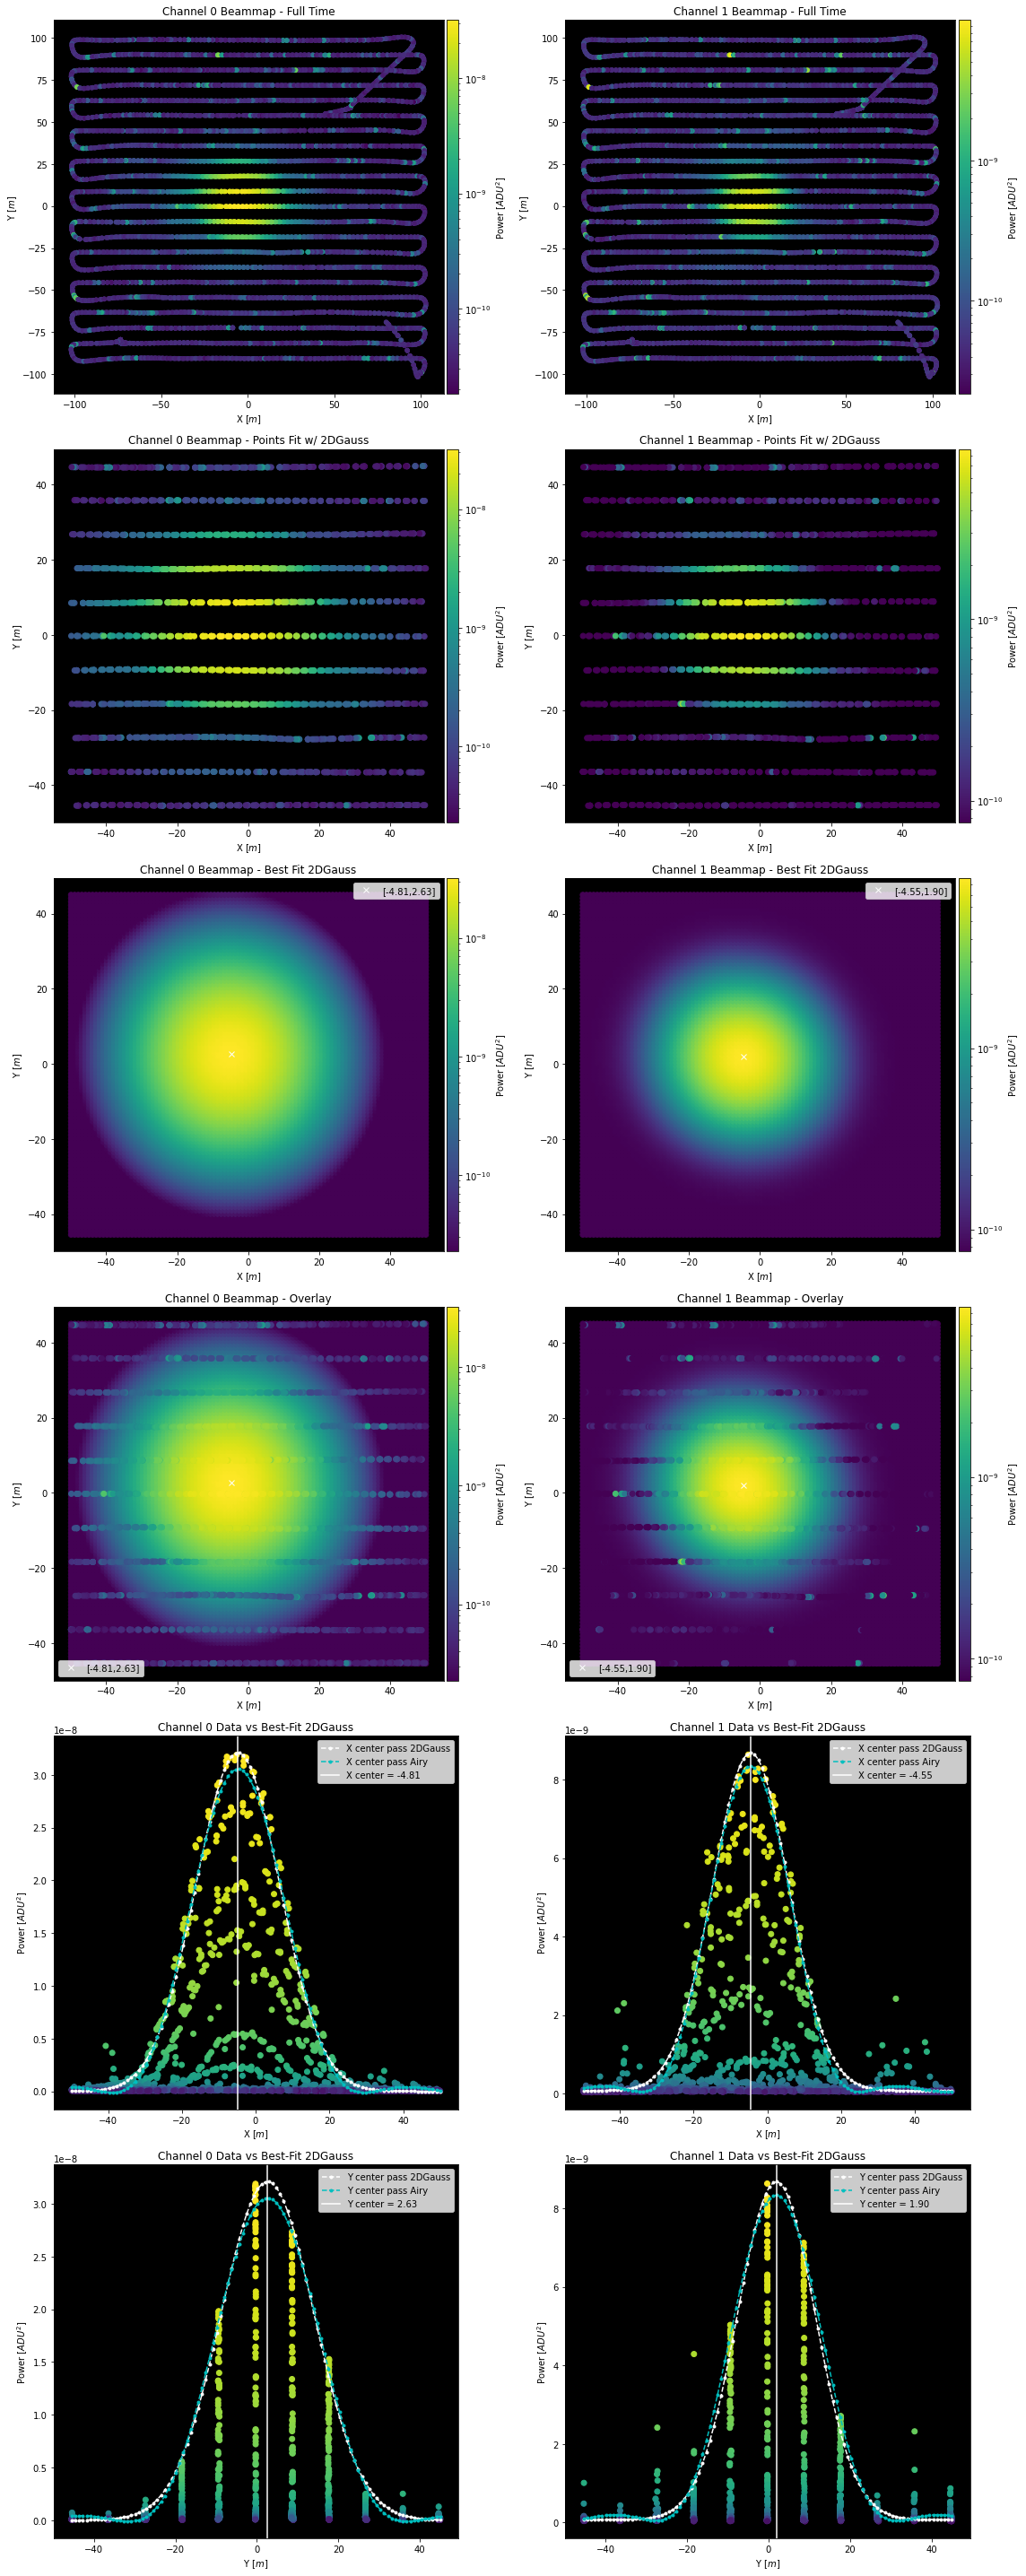

In [13]:
## OBJECTIVE 5C: concat Function: Synchronization_Function

## This function finds the absolute timing shift between the dji data from the drone and the correlator
    ## We will be loading t_delta_dji from the config file to save some time!
    ## This function only works if the source was pulsed and if V_bgsub was created using background subtraction.
    ## This function works by zooming into the gaussian main beam and removing saturated data points...
## To run, you must give the following:
    ## inputcorr  = the corr class used in the concat
    ## inputdrone = the drone class used in the concat
## The optional parameters and their default values are listed below:
    ## coarse_params=[-10.0,10.0,0.2]    = the min,max,step parameters for the coarse time offset array
    ## fine_params=[-0.5,0.5,0.01]       = the min,max,step parameters for the fine time offset array
    ## chans=np.arange(0,2)              = the channels to fit. 0,1 gives us each polarization
    ## freqs=np.arange(100,1024,150)     = the min,max,step parameters for the freq array axis
    ## FMB_coordbounds=[50.0,50.0,150.0] = the cartesian coords we restrict around the main beam
        # x within +/- 50m from dish center in Local Cartesian (LC)
        # y within +/- 50m from dish center in Local Cartesian (LC)
        # z > 150m from dish center in Local Cartesian (LC)
    ## FMB_ampbound=0.999                = amplitude percentile threshold for saturation... 
        # time indices where the amplitude exceeds 0.999*maximum value are excluded because they are saturated

concattest0825.Synchronization_Function(inputcorr=corrtest0825,inputdrone=dronetest0825,FMB_coordbounds=[50.0,50.0,150.0],FMB_ampbound=0.999)

## Since we are loading from the config, we get to skip an iterative loop and just take the solution and apply it.
    ## The verification plot shown is hidden when traceback==False is set in the concat initialization
    ## Look closely at the verification plots to see which channel appears to be the co-pol (channel 1)
    ## In the bottom 2 panels, compare the fit result (white gaussian) to the data points (in color)
        ## We are omitting the saturated points to find the REAL max value, instead of squashing our peak
        ## If we are satisfied with this fit, we should try to save the parameters we found...

In [18]:
## OBJECTIVE 5D: concat Function: Export_yaml

## When we have results we want to save, we should export our results to a config file for future use:
    ## The file will be written to the directory stated when the concat class was initialized.
    ## If a concat config yaml file already exists, a new version will be saved.
## Uncomment this if you want to export a config file... 
#concattest0825.Export_yaml()

Preparing to export configuration file:
  --> Checking directory for config_FLY535_20210826T192056Z.yaml:
    --> FILE EXISTS
    --> preparing to write a new versioned configuration file...
    --> file saved successfully


In [ ]:
## OBJECTIVE 5E: concat Function: Main_Beam_Fitting

## Now we can do some analysis, since we have synchronized useful data. We can begin by fitting the main beam:
    ## You can specify the directory where you want the fit params to be output:
    ## fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
    ## This one sometimes takes a while, feel free to get a coffee or something.
concattest0825.Main_Beam_Fitting(fit_param_directory='/hirax/GBO_Analysis_Outputs/main_beam_fits/')

Performing 2DGauss and Airy fits for [8]chans x [1024]freqs:


/home/ln267/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


  --> Saving output fit parameters as an .npz filetype:
  --> FLY534_20210826T185621Z_ver_20230206T132003_2dGauss_and_Airy_Params.npz


In [29]:
## Now we can examine the Gaussian results, if we so choose:
    #print channel 1, freq 900, all gauss params: [amp0,x00,xsig0,y00,ysig0,theta0,bg0]
print(concattest0825.G_popt[1,900,:])


[ 3.71307407e-07 -4.58175121e+00  9.19170875e+00  2.24372484e+00
  8.77428065e+00  2.85671537e-02  5.92802827e-09]


16 1024 7


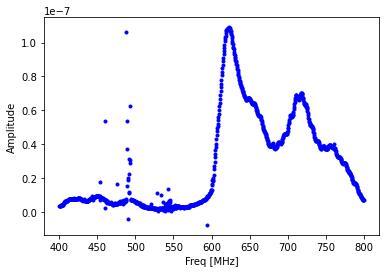

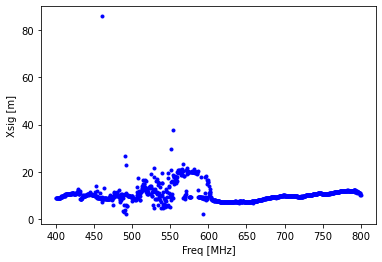

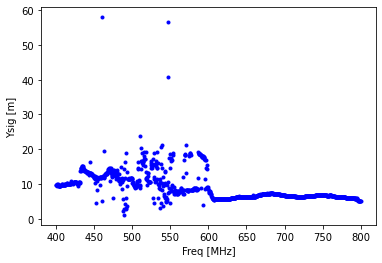

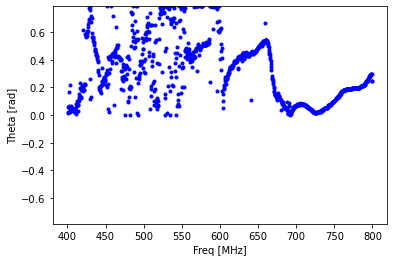

In [16]:
print(len(concattest0825.G_popt[:,0,0]),len(concattest0825.G_popt[0,:,0]),len(concattest0825.G_popt[0,0,:]))
N = len(concattest0825.G_popt[0,:,0])


plt.plot(freqs,concattest0825.G_popt[0,:,0],'b.')
plt.ylabel('Amplitude')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,concattest0825.G_popt[0,:,2],'b.')
plt.ylabel('Xsig [m]')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,concattest0825.G_popt[0,:,4],'b.')
plt.ylabel('Ysig [m]')
plt.xlabel('Freq [MHz]')
plt.show()

plt.plot(freqs,np.abs(concattest0825.G_popt[0,:,5]),'b.')
plt.ylabel('Theta [rad]')
plt.xlabel('Freq [MHz]')
plt.ylim(-np.pi/4,np.pi/4)
plt.show()

In [ ]:
## Let's make a nice beammap using the data we just analyzed:
    ## First lets find time index bounds that select only the nice grid passes, no extra stuff: [6900,28300]
    ## These points appear as orange, and show just the grid in graph 3:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
tlb,tub=[0,-1]
ax1.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[0:-1,400,0],'.')
ax2.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[0:-1,400,1],'.')
ax3.plot(concattest0825.drone_xyz_LC_interp[tlb:tub,0],concattest0825.drone_xyz_LC_interp[tlb:tub,1],'.')
tlb,tub=[14800,25000]
ax1.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb:tub,400,0],'.')
ax2.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb:tub,400,1],'.')
ax3.plot(concattest0825.drone_xyz_LC_interp[tlb:tub,0],concattest0825.drone_xyz_LC_interp[tlb:tub,1],'.')
#ax1.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb-1000:tlb,400,0],'.')
#ax2.semilogy(concattest0825.t_index[tlb:tub],concattest0825.V[tlb-1000:tlb,400,400,1],'.')
#ax3.plot(concattest0825.drone_xyz_LC_interp[tlb:tub,0],concattest0825.drone_xyz_LC_interp[tlb:tub,1],'.')

In [ ]:
## Now we can execute the Plot_Beammap function from plotting_utils.py:
    ## We should use the t_bounds we just found [6900,28300] to restrict to a nice grid
    ## We can choose coord_args to see if we want cartesian or polar: {"LC","Pol"}
    ## We can choose pulse_args to see what correlator data we want: {None,"on","off","bg","bgsub"}
    
## First lets see the source on indices in cartesian:
pu.Plot_Beammap(concattest0825,coord_args='LC',pulse_args="on",\
                t_bounds=[tlb,tub],f_bounds=[900,910],cbounds=[],dotsize=20)

In [ ]:
## We can also look at, for instance, the Polar background subtracted beammap:
pu.Plot_Beammap(concattest0825,coord_args='Pol',pulse_args='bgsub',\
                t_bounds=[6900,28300],f_bounds=[900,910],cbounds=[],dotsize=20)

In [ ]:
plot(concattest0825.drone_xyz_LC_interp[6920:7800,0],concattest0825.drone_xyz_LC_interp[6920:7800,1])
plot(concattest0825.drone_xyz_LC_interp[7900:8200,0],concattest0825.drone_xyz_LC_interp[7900:8200,1])
dx=(concattest0825.drone_xyz_LC_interp[8200,0]-concattest0825.drone_xyz_LC_interp[7900,0])
dt=((concattest0825.t_arr_datetime[8200]-concattest0825.t_arr_datetime[7900]).total_seconds())

print("for a sample data set of {} time indices...".format(str(300)))
print("--> the timestep is are {} sec".format(concattest0825.tstep))
print("--> the total duration is  {} sec".format(dt))
print("--> the distance travelled is {} m".format(dx))
print("--> the angular distance travelled is {} deg".format(180/np.pi*np.arctan(dx/np.nanmean(concattest0825.drone_xyz_LC_interp[7900:8200,2]))))
print("--> the average velocity is {} m/s".format(dx/dt))
print("--> the angular velocity is {} deg/s".format(180/np.pi*np.arctan(dx/np.nanmean(concattest0825.drone_xyz_LC_interp[7900:8200,2]))/dt))
print("--> the angular step size (per time index) is {} deg".format(180/np.pi*np.arctan(dx/np.nanmean(concattest0825.drone_xyz_LC_interp[7900:8200,2]))/300))


In [ ]:
## Plot for Maile:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(16,6))
for freq in [600]:
    plot(concattest0825.t_index[16750:17200],concattest0825.V[16750:17200,freq,1],'k',marker='.',linestyle='None',alpha=0.85,label="{:.2f}MHz".format(concattest0825.freq[freq]))
    t_custom=np.intersect1d(concattest0825.inds_on,concattest0825.t_index[16750:17200])
    plot(t_custom,concattest0825.V[t_custom,freq,1],'r^',alpha=0.85,label="Source On")
    t_custom=np.intersect1d(concattest0825.inds_off,concattest0825.t_index[16750:17200])
    plot(t_custom,concattest0825.V[t_custom,freq,1],'bv',alpha=0.85,label="Source Off")

ax1.set_title("Raw Telescope Data During Drone Transit",size=24)
ax1.set_ylabel("Uncalibrated Power [$ADU^2$]",size=20)
ax1.set_xlabel("Time Index",size=20)
ax1.legend(fontsize=20)
tight_layout()

# SCRATCH BELOW :::

In [34]:
import numpy as np
from matplotlib.pyplot import *
from scipy.optimize import least_squares
from astropy.modeling.models import AiryDisk2D
from scipy.stats import pearsonr

def Gauss(x,a,x0,sigma,k):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k

def Airy_2d_LC_opt(P,x,y,V):
    AD=AiryDisk2D(1,5,5,radius=1)
    amp,x0,y0,rad,c=P
    return AD.evaluate(x,y,amp,x0,y0,rad)+c-V

def Airy_2d_LC_func(P,x,y):
    AD=AiryDisk2D(1,5,5,radius=1)
    amp,x0,y0,rad,c=P
    return AD.evaluate(x,y,amp,x0,y0,rad)+c

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V

def Fit_Main_Beam(inputconcat,chans,freqs,coordbounds=[50.0,50.0,150.0],ampbound=0.999):
    A_popt=np.zeros((len(chans),len(freqs),5))
    A_PR=np.zeros((len(chans),len(freqs)))
    G_popt=np.zeros((len(chans),len(freqs),7))
    G_PR=np.zeros((len(chans),len(freqs)))
    ## define timecuts for cartesian coordinates:
    txcut=inputconcat.t_index[np.abs(inputconcat.drone_xyz_LC_interp[:,0])<coordbounds[0]]
    tycut=inputconcat.t_index[np.abs(inputconcat.drone_xyz_LC_interp[:,1])<coordbounds[1]]
    tzcut=inputconcat.t_index[np.abs(inputconcat.drone_xyz_LC_interp[:,2])>coordbounds[2]]
    coordcut=np.intersect1d(np.intersect1d(txcut,tycut),tzcut)
    for i,chan in enumerate(chans):
        for j,find in enumerate(freqs):
            #try:
                ## apply amplitude cut:
                tacut=inputconcat.t_index[inputconcat.V[:,find,chan]<ampbound*(np.nanmax(inputconcat.V[:,find,chan]))]
                #try:
                ttcut=np.intersect1d(np.intersect1d(coordcut,tacut),inputconcat.inds_on)
                #except AttributeError:
                #    ttcut=np.intersect1d(coordcut,tacut)                    
                ## pull the proper coords for fitting:
                mbx=inputconcat.drone_xyz_LC_interp[ttcut,0]
                mby=inputconcat.drone_xyz_LC_interp[ttcut,1]
                mbz=inputconcat.drone_xyz_LC_interp[ttcut,2]
                mbV=inputconcat.V[ttcut,find,chan]
                mb_input_data=np.array([mbx,mby,mbV])
                ## shared params:
                amp0=np.nanmax(mbV)
                bg0=np.nanmin(mbV)
                x00=inputconcat.dish_coords[int(chan/2),0]
                y00=inputconcat.dish_coords[int(chan/2),1]
                ## airy params:
                rad0=25.0
                ## 2dgauss params:
                xsig0=6.0
                ysig0=6.0
                theta0=0.0
                ## initial guess and bounds:
                pA=np.array([amp0,x00,y00,rad0,bg0])
                pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
                ## run the fits:
                bnds = ((-np.inf, -np.inf,-np.inf, -np.inf,-np.inf, -np.pi/4,-np.inf),
                        (np.inf, np.inf,np.inf, np.inf,np.inf, np.pi/4,np.inf))
                A_popt[i,j]=least_squares(Airy_2d_LC_opt,x0=pA,args=mb_input_data).x
                A_PR[i,j]=pearsonr(mbV,Airy_2d_LC_func(A_popt[i,j,:],mbx,mby))[0]
                G_popt[i,j]=least_squares(Gauss_2d_LC_opt,x0=pG,bounds=bnds,method='trf',args=mb_input_data).x
                G_PR[i,j]=pearsonr(mbV,Gauss_2d_LC_func(G_popt[i,j,:],mbx,mby))[0]
                print(i, j, chan, G_popt[i,j])
            #except ValueError:
            #    A_popt[i,j,:]=np.NAN*np.zeros(5)
            #    A_PR[i,j]=np.NAN
            #    G_popt[i,j,:]=np.NAN*np.zeros(7)
            #    G_PR[i,j]=np.NAN
    return A_popt,A_PR,G_popt,G_PR

A_popt,A_PR,G_popt,G_PR = Fit_Main_Beam(concattest0825,chans=concattest0825.chmap,freqs=[400])
#print(fits)



0 0 0 [ 8.08347354e-08  1.29575124e+00  1.13039660e+01  8.31986032e+00
  8.82585176e+00 -3.09083449e-02  4.09024211e-09]
1 0 1 [1.23881535e-07 3.52713661e+00 2.74159967e+00 5.49501023e-01
 1.10662893e+01 2.63110426e-01 3.81928346e-09]
2 0 3 [ 1.14301625e-07 -1.43707933e+01  2.54629136e+00 -1.09768953e+01
  1.01970056e+01  1.90826132e-01  4.68639330e-09]
3 0 2 [ 2.84320483e-07 -2.18259092e+01  2.48141949e+00 -1.09398494e+01
  1.05602611e+01 -2.22850011e-01  5.42502672e-09]
4 0 4 [ 8.38997894e-08 -9.43167724e+00  9.20206173e+00  1.84899262e+01
  1.47428169e+01 -2.35203996e-01  1.10144646e-08]
5 0 5 [ 1.80400717e-08 -1.13640353e+01 -8.03038292e+00  1.39488042e+01
 -3.47914979e-01 -7.21384839e-01  1.54970634e-08]
6 0 7 [ 2.09875969e-07 -3.61366875e+00  2.55001505e+00 -9.44979954e+00
  1.09647642e+01 -2.16112292e-01  1.03181948e-08]
7 0 6 [ 1.49984606e-09 -7.74288370e+00  4.48227388e+00 -2.00991767e+00
  7.56815390e+00  1.28631340e-06  9.68799217e-12]


In [38]:
#print(G_popt)

f = 0
for i in range(0,7):
    #if (i in Epols):
        #ax.plot(freqs,fits['G_popt'][i,:,0],marker='.',ms=1,linestyle='None',label=str(i))
    #    print('in Epols',i,fits['G_popt'][i,f,0])
    #if (i in Npols):
        #ax.plot(freqs,fits['G_popt'][i,:,0],marker='s',ms=3,linestyle='None',label=str(i))
        print(i,G_popt[i,0,0])
    #ax.set_ylim(0,4E-7)
    #ax.set_xlim(400,575)
    #ylabel('Gaussian fit amplitude')
    #xlabel('Frequency [MHz]')
    #title('Flight 535')
#ax.legend(markerscale=3)
#fig.show()

0 8.083473544275906e-08
1 1.238815351433238e-07
2 1.1430162532348734e-07
3 2.843204834960844e-07
4 8.389978943995644e-08
5 1.8040071663165356e-08
6 2.0987596928167105e-07
